In [1]:
# %%
# =============================================================================
# 1. IMPORTS AND CONFIGURATION
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from timm import create_model
import os
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import seaborn as sns
import json

warnings.filterwarnings('ignore')

# Configuration pointing to the timm model ID
config = {
    'base_dir': r'A:\Speech Journal\melspectrograms_dataset',
    'model_name': 'cait_s24_224',  # CHANGED: Removed the '.in1k' suffix
    'batch_size': 16,
    'img_size': 224,
    'weight_decay': 0.01,
    'epochs': 80,
    'num_workers': 0,
    'pin_memory': True,
    'patience': 12,
    'drop_rate': 0.4,
    'head_lr': 1e-3,
    'head_epochs': 10,
    'full_train_lr': 5e-5,
    'lr_warmup_epochs': 5,
    'label_smoothing': 0.1,
    'mixup_alpha': 0.4
}

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# =============================================================================
# 2. DATASET CLASS (No Changes Needed)
# =============================================================================
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split='train', transform=None):
        self.split = split
        self.transform = transform
        self.data_dir = os.path.join(base_dir, split)
        self.classes = sorted([d for d in os.listdir(self.data_dir)
                               if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_file))
                    self.labels.append(self.class_to_idx[class_name])

        print(f"Found {len(self.image_paths)} images in {split} set")
        print(f"Classes: {self.classes}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# =============================================================================
# 3. TRANSFORMS AND DATALOADERS
# =============================================================================
def get_enhanced_transforms(img_size):
    # CHANGED: Use standard ImageNet normalization for timm models
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    print(f"Using standard ImageNet normalization: mean={mean}, std={std}")

    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    return train_transform, val_transform

train_transform, val_transform = get_enhanced_transforms(config['img_size'])
train_dataset = MelSpectrogramDataset(config['base_dir'], 'train', train_transform)
val_dataset = MelSpectrogramDataset(config['base_dir'], 'validation', val_transform)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'], pin_memory=config['pin_memory'])
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'], pin_memory=config['pin_memory'])

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# =============================================================================
# 4. AUGMENTATION (No Changes Needed)
# =============================================================================
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param, time_mask_param, num_freq_masks=1, num_time_masks=1):
        super(SpecAugment, self).__init__()
        self.F, self.T = freq_mask_param, time_mask_param
        self.num_freq_masks, self.num_time_masks = num_freq_masks, num_time_masks

    def forward(self, x):
        sh = x.shape
        for _ in range(self.num_freq_masks):
            f = np.random.uniform(0.0, self.F)
            f0 = np.random.randint(0, sh[2] - int(f)) if sh[2] > int(f) else 0
            x[:, :, f0:f0+int(f), :] = 0
        for _ in range(self.num_time_masks):
            t = np.random.uniform(0.0, self.T)
            t0 = np.random.randint(0, sh[3] - int(t)) if sh[3] > int(t) else 0
            x[:, :, :, t0:t0+int(t)] = 0
        return x

spec_augment = SpecAugment(freq_mask_param=25, time_mask_param=40).to(device)

def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# =============================================================================
# 5. MODEL DEFINITION (Using timm)
# =============================================================================
# CHANGED: Replaced TransformersClassifier with TimmClassifier
class TimmClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.3):
        super().__init__()
        # Load the backbone using create_model from the timm library
        self.backbone = create_model(
            model_name,
            pretrained=True,
            num_classes=0  # Set to 0 to remove the final classifier
        )
        
        # Get the feature dimension from the model
        feature_dim = self.backbone.num_features
        print(f"Feature dimension from timm model: {feature_dim}")

        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # The timm model directly outputs features after pooling
        features = self.backbone(x)
        return self.classifier(features)

model = TimmClassifier(
    config['model_name'], num_classes, config['drop_rate']
).to(device)
print("✅ Model created successfully using the timm library!")

# =============================================================================
# 6. TRAINING & VALIDATION LOOPS (No Changes Needed)
# =============================================================================
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, all_preds, all_labels = 0.0, [], []
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        images = spec_augment(images)
        images, targets_a, targets_b, lam = mixup_data(images, labels, config['mixup_alpha'])
        optimizer.zero_grad()
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    return running_loss / len(dataloader), accuracy_score(all_labels, all_preds)

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, all_preds, all_labels = 0.0, [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    return running_loss / len(dataloader), accuracy_score(all_labels, all_preds), all_preds, all_labels

Using standard ImageNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
Found 4021 images in train set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Found 73 images in validation set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Number of classes: 6
Feature dimension from timm model: 384
✅ Model created successfully using the timm library!


In [3]:
# =============================================================================
# 7. PHASE 1: HEAD TRAINING
# =============================================================================
print("\n=== PHASE 1: Training only the classification head ===")
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
optimizer = optim.AdamW(model.classifier.parameters(), lr=config['head_lr'], weight_decay=config['weight_decay'])
best_head_acc = 0

for epoch in range(config['head_epochs']):
    print(f"\nEpoch {epoch+1}/{config['head_epochs']}")
    original_mixup_alpha = config['mixup_alpha']
    config['mixup_alpha'] = 0.0
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
    config['mixup_alpha'] = original_mixup_alpha
    print(f"Head Training - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    if val_acc > best_head_acc:
        best_head_acc = val_acc
        torch.save(model.state_dict(), 'best_head_model.pth')
        print(f"✅ New best head model saved! Accuracy: {val_acc:.4f}")

print(f"\n🎯 Phase 1 completed! Best head accuracy: {best_head_acc:.4f}")
model.load_state_dict(torch.load('best_head_model.pth'))




=== PHASE 1: Training only the classification head ===

Epoch 1/10


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s, Loss=1.2231]


Head Training - Train Loss: 1.2189, Acc: 0.5832 | Val Loss: 1.1565, Acc: 0.6301
✅ New best head model saved! Accuracy: 0.6301

Epoch 2/10


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s, Loss=1.1605]


Head Training - Train Loss: 1.0915, Acc: 0.6566 | Val Loss: 1.1391, Acc: 0.6575
✅ New best head model saved! Accuracy: 0.6575

Epoch 3/10


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s, Loss=1.1014]


Head Training - Train Loss: 1.0769, Acc: 0.6595 | Val Loss: 1.0675, Acc: 0.6301

Epoch 4/10


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s, Loss=0.7885]


Head Training - Train Loss: 1.0485, Acc: 0.6752 | Val Loss: 1.1032, Acc: 0.6164

Epoch 5/10


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s, Loss=1.1109]


Head Training - Train Loss: 1.0349, Acc: 0.6812 | Val Loss: 1.0779, Acc: 0.6849
✅ New best head model saved! Accuracy: 0.6849

Epoch 6/10


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s, Loss=1.4406]


Head Training - Train Loss: 1.0271, Acc: 0.6956 | Val Loss: 1.1376, Acc: 0.6575

Epoch 7/10


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s, Loss=0.7318]


Head Training - Train Loss: 1.0213, Acc: 0.6946 | Val Loss: 1.0612, Acc: 0.7123
✅ New best head model saved! Accuracy: 0.7123

Epoch 8/10


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s, Loss=0.9231]


Head Training - Train Loss: 1.0136, Acc: 0.6993 | Val Loss: 1.1176, Acc: 0.7123

Epoch 9/10


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s, Loss=1.0723]


Head Training - Train Loss: 1.0020, Acc: 0.7023 | Val Loss: 1.0594, Acc: 0.7123

Epoch 10/10


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s, Loss=0.9024]


Head Training - Train Loss: 0.9907, Acc: 0.7157 | Val Loss: 1.0771, Acc: 0.6301

🎯 Phase 1 completed! Best head accuracy: 0.7123


<All keys matched successfully>

In [4]:
# =============================================================================
# 8. PHASE 2: FULL NETWORK TRAINING
# =============================================================================
print("\n=== PHASE 2: Full network training ===")
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=config['full_train_lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0

for epoch in range(config['epochs']):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
    scheduler.step()
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Full Training - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_full_model.pth')
        print(f"🎯 New best full model saved! Accuracy: {val_acc:.4f}")

print(f"\nPhase 2 completed! Best validation accuracy: {best_val_acc:.4f}")




=== PHASE 2: Full network training ===

Epoch 1/80


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s, Loss=0.9008]


Full Training - Train Loss: 1.3132, Acc: 0.4472 | Val Loss: 1.0716, Acc: 0.6575
Learning Rate: 5.00e-05
🎯 New best full model saved! Accuracy: 0.6575

Epoch 2/80


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s, Loss=0.6605]


Full Training - Train Loss: 1.1752, Acc: 0.4636 | Val Loss: 0.9553, Acc: 0.7671
Learning Rate: 4.99e-05
🎯 New best full model saved! Accuracy: 0.7671

Epoch 3/80


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s, Loss=0.8693]


Full Training - Train Loss: 1.1152, Acc: 0.4979 | Val Loss: 0.8768, Acc: 0.7671
Learning Rate: 4.98e-05

Epoch 4/80


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s, Loss=0.7007]


Full Training - Train Loss: 1.0221, Acc: 0.5459 | Val Loss: 0.7429, Acc: 0.8767
Learning Rate: 4.97e-05
🎯 New best full model saved! Accuracy: 0.8767

Epoch 5/80


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s, Loss=0.8470]


Full Training - Train Loss: 0.9780, Acc: 0.5859 | Val Loss: 0.8041, Acc: 0.8630
Learning Rate: 4.95e-05

Epoch 6/80


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s, Loss=0.7852]


Full Training - Train Loss: 0.9501, Acc: 0.5690 | Val Loss: 0.8061, Acc: 0.8493
Learning Rate: 4.93e-05

Epoch 7/80


Training:   5%|▌         | 13/252 [00:29<09:04,  2.28s/it, Loss=0.5250]


KeyboardInterrupt: 


=== FINAL EVALUATION ON TEST SET ===
Found 74 images in test set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s, Loss=0.6235]


Final Test Accuracy: 0.8108 (81.08%)
Final Test Loss: 0.8019

Test Set Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.5000    0.3077    0.3810        13
           Laryngozele     0.6154    0.8889    0.7273         9
           Vox senilis     0.8462    0.8462    0.8462        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.7857    0.8462    0.8148        13

              accuracy                         0.8108        74
             macro avg     0.7912    0.8148    0.7949        74
          weighted avg     0.8007    0.8108    0.7985        74



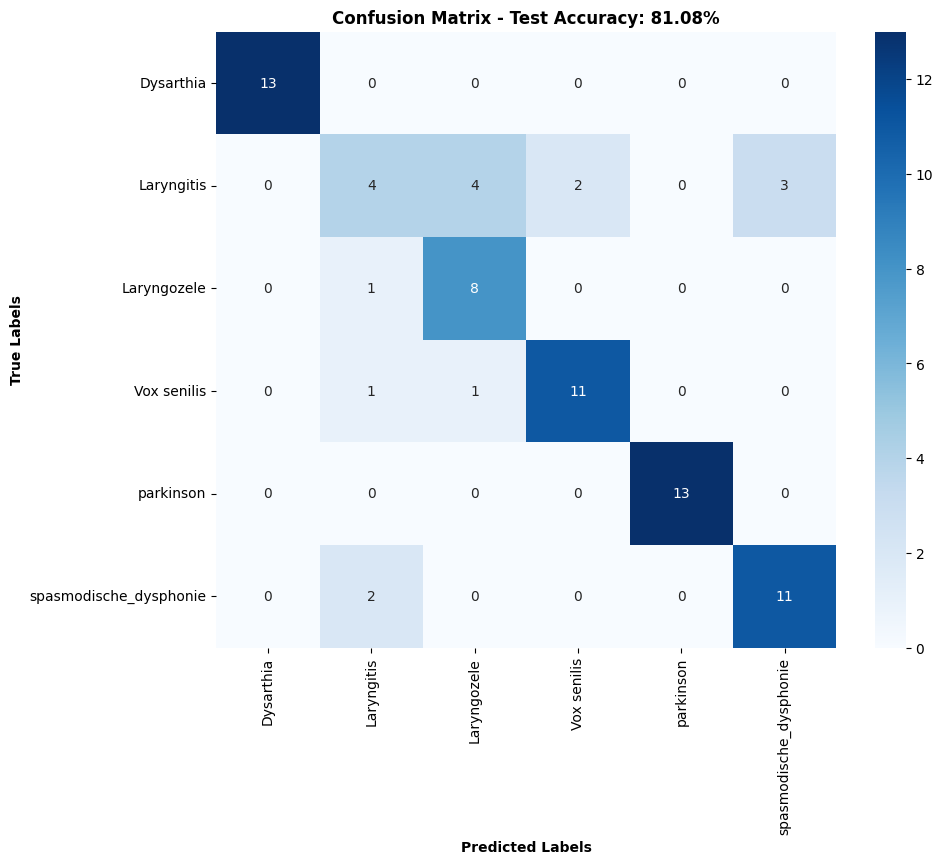

Current best validation accuracy: 87.67%.


In [5]:
# =============================================================================
# 9. FINAL EVALUATION
# =============================================================================
print("\n=== FINAL EVALUATION ON TEST SET ===")
model.load_state_dict(torch.load('best_full_model.pth'))
test_dataset = MelSpectrogramDataset(config['base_dir'], 'test', val_transform)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'], pin_memory=config['pin_memory'])
test_loss, test_acc, test_preds, test_labels = validate_epoch(model, test_loader, criterion, device)
print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc:.2%})")
print(f"Final Test Loss: {test_loss:.4f}")
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=test_dataset.classes, digits=4))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Labels', fontweight='bold')
plt.ylabel('True Labels', fontweight='bold')
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.2%}', fontweight='bold')
plt.show()

if best_val_acc >= 0.90:
    print("🚀 CONGRATULATIONS! 90%+ VALIDATION ACCURACY ACHIEVED! 🚀")
else:
    print(f"Current best validation accuracy: {best_val_acc:.2%}.")

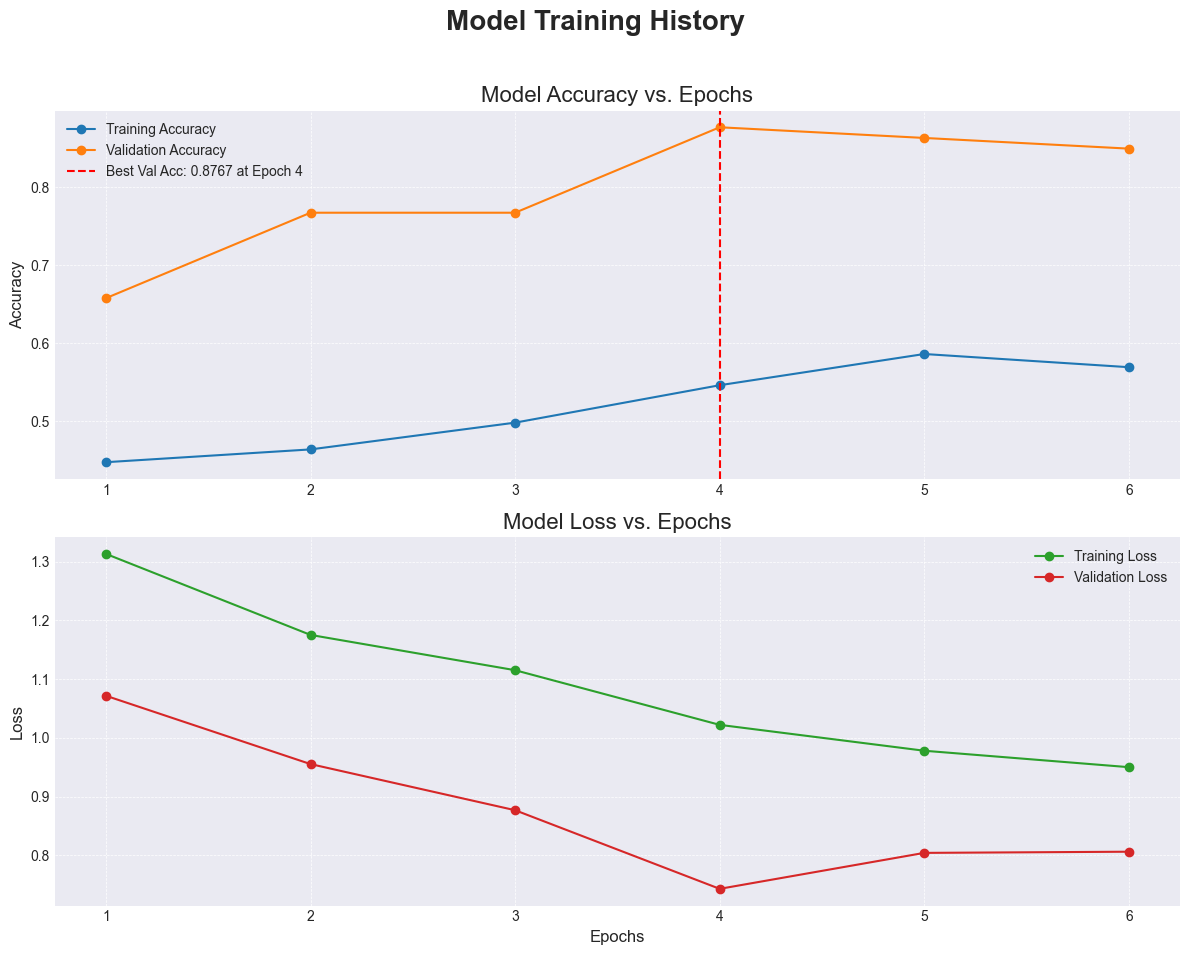

In [6]:
import matplotlib.pyplot as plt

# Ensure the 'history' dictionary from your training is available
if 'history' not in locals():
    print("Error: The 'history' dictionary is not defined.")
    print("Please run the training cell or manually reconstruct the history dictionary first.")
else:
    # Get the number of epochs the training actually ran for
    epochs_ran = range(1, len(history['train_loss']) + 1)

    # Set up the plots
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle('Model Training History', fontsize=20, fontweight='bold')

    # --- Plot 1: Model Accuracy ---
    ax1.plot(epochs_ran, history['train_acc'], 'o-', label='Training Accuracy', color='C0')
    ax1.plot(epochs_ran, history['val_acc'], 'o-', label='Validation Accuracy', color='C1')
    ax1.set_title('Model Accuracy vs. Epochs', fontsize=16)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Find and highlight the best epoch for validation accuracy
    best_epoch = history['val_acc'].index(max(history['val_acc'])) + 1
    best_acc_val = max(history['val_acc'])
    ax1.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Val Acc: {best_acc_val:.4f} at Epoch {best_epoch}')
    ax1.legend()

    # --- Plot 2: Model Loss ---
    ax2.plot(epochs_ran, history['train_loss'], 'o-', label='Training Loss', color='C2')
    ax2.plot(epochs_ran, history['val_loss'], 'o-', label='Validation Loss', color='C3')
    ax2.set_title('Model Loss vs. Epochs', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Display the plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

In [7]:
# %%
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

print("🚀 STARTING FINAL FINE-TUNING PHASE 🚀")

# --- 1. Configuration for Fine-Tuning ---
FT_EPOCHS = 10                  
FT_LEARNING_RATE = 5e-6         
BEST_MODEL_PATH = 'best_full_model.pth'
FINETUNED_MODEL_PATH = 'best_finetuned_model.pth'

# --- 2. Load Data and Model ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use validation transforms for both train and val (no augmentation)
_, ft_transform = get_enhanced_transforms(config['img_size'])
train_dataset_ft = MelSpectrogramDataset(config['base_dir'], 'train', ft_transform)
val_dataset_ft = MelSpectrogramDataset(config['base_dir'], 'validation', ft_transform)

train_loader_ft = DataLoader(train_dataset_ft, batch_size=config['batch_size'], shuffle=True)
val_loader_ft = DataLoader(val_dataset_ft, batch_size=config['batch_size'], shuffle=False)

num_classes = len(train_dataset_ft.classes)

# Instantiate and load model
# CHANGED: Use TimmClassifier here as well
model = TimmClassifier(
    config['model_name'], num_classes, config['drop_rate']
).to(device)
print("✅ Model created successfully using the timm library!")

model.load_state_dict(torch.load(BEST_MODEL_PATH))
print(f"✅ Successfully loaded weights from '{BEST_MODEL_PATH}'")

# --- 3. Setup for Fine-Tuning ---
optimizer = optim.AdamW(
    model.parameters(), 
    lr=FT_LEARNING_RATE, 
    weight_decay=config['weight_decay'] * 0.1
)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=FT_EPOCHS, eta_min=FT_LEARNING_RATE * 0.1)
criterion = torch.nn.CrossEntropyLoss()

# --- 4. Run Fine-Tuning Loop ---
best_ft_acc = 0.0

original_mixup = config.get('mixup_alpha', 0.4)
config['mixup_alpha'] = 0.0  # Disable mixup

for epoch in range(FT_EPOCHS):
    print(f"\n🎯 Fine-Tuning Epoch {epoch+1}/{FT_EPOCHS}")
    print(f"   Current LR: {optimizer.param_groups[0]['lr']:.2e}")

    train_loss, train_acc = train_epoch(model, train_loader_ft, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader_ft, criterion, device)
    scheduler.step()

    print(f"📈 FT - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"📊 FT - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_ft_acc:
        best_ft_acc = val_acc
        torch.save(model.state_dict(), FINETUNED_MODEL_PATH)
        print(f"💾 New best fine-tuned model saved! Acc: {val_acc:.4f}")

config['mixup_alpha'] = original_mixup

print(f"\n✅ Fine-tuning complete! Best accuracy: {best_ft_acc:.4f}")
print(f"💾 Final model saved to '{FINETUNED_MODEL_PATH}'")

🚀 STARTING FINAL FINE-TUNING PHASE 🚀
Using standard ImageNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
Found 4021 images in train set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Found 73 images in validation set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Feature dimension from timm model: 384
✅ Model created successfully using the timm library!
✅ Successfully loaded weights from 'best_full_model.pth'

🎯 Fine-Tuning Epoch 1/10
   Current LR: 5.00e-06


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s, Loss=0.3637]


📈 FT - Train Loss: 0.2694, Train Acc: 0.9329
📊 FT - Val Loss: 0.4415, Val Acc: 0.8630
💾 New best fine-tuned model saved! Acc: 0.8630

🎯 Fine-Tuning Epoch 2/10
   Current LR: 4.89e-06


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s, Loss=0.3821]


📈 FT - Train Loss: 0.1568, Train Acc: 0.9622
📊 FT - Val Loss: 0.4690, Val Acc: 0.8767
💾 New best fine-tuned model saved! Acc: 0.8767

🎯 Fine-Tuning Epoch 3/10
   Current LR: 4.57e-06


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s, Loss=0.2240]


📈 FT - Train Loss: 0.1074, Train Acc: 0.9744
📊 FT - Val Loss: 0.4355, Val Acc: 0.8767

🎯 Fine-Tuning Epoch 4/10
   Current LR: 4.07e-06


Training:   1%|          | 3/252 [00:22<31:42,  7.64s/it, Loss=0.0849]


KeyboardInterrupt: 

🧪 EVALUATING FINE-TUNED MODEL ON TEST DATA
Using standard ImageNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
Found 74 images in test set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
📊 Test dataset: 74 samples
🎯 Number of classes: 6
📝 Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Feature dimension from timm model: 384
✅ Loaded fine-tuned model from: best_finetuned_model.pth
🔍 Generating predictions on test data...


Processing test batches: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


✅ Test Accuracy: 0.8378 (83.78%)


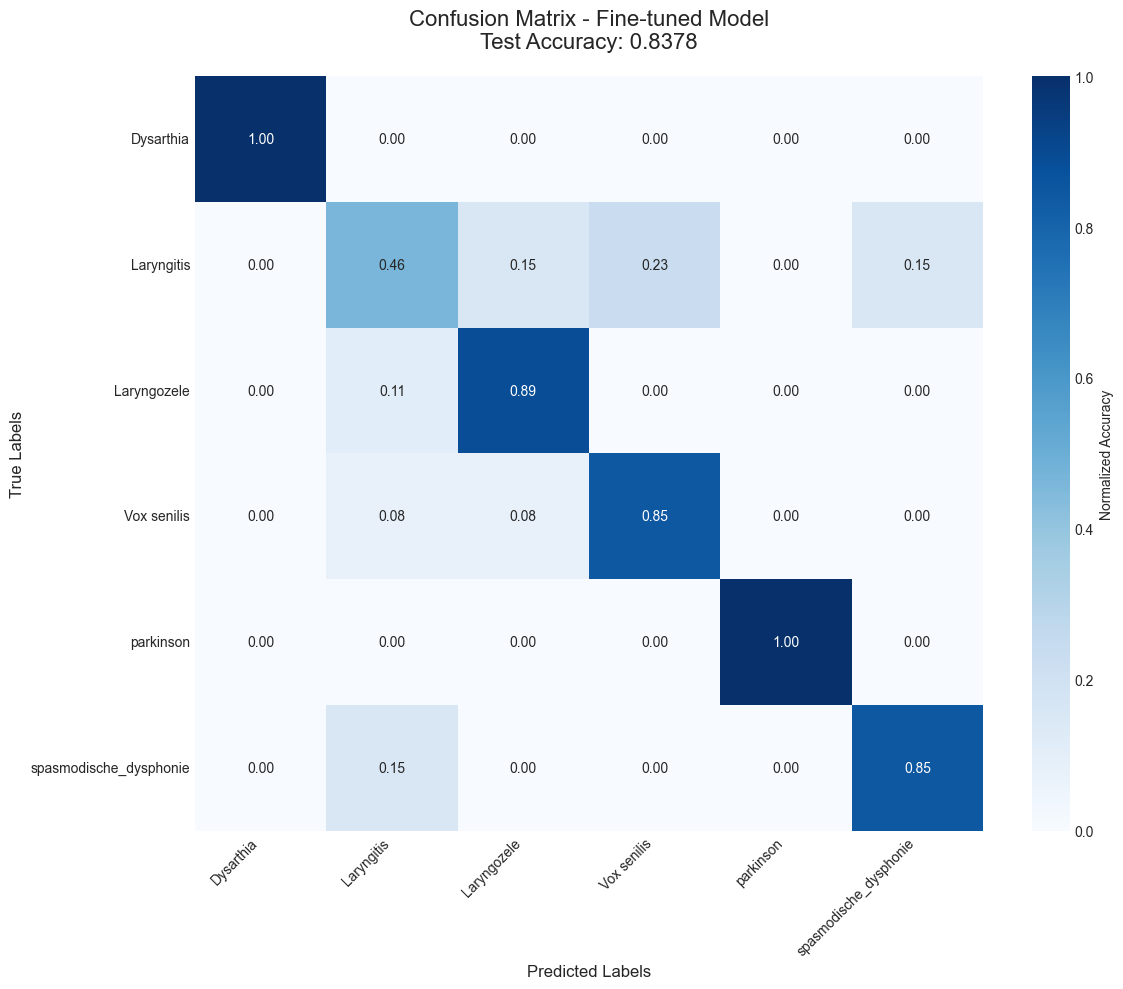


📊 DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6000    0.4615    0.5217        13
           Laryngozele     0.7273    0.8889    0.8000         9
           Vox senilis     0.7857    0.8462    0.8148        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8462    0.8462    0.8462        13

              accuracy                         0.8378        74
             macro avg     0.8265    0.8405    0.8305        74
          weighted avg     0.8319    0.8378    0.8321        74


🔍 CONFUSION MATRIX ANALYSIS

Top Misclassifications:
  Laryngitis → Vox senilis: 3 samples
  Laryngitis → Laryngozele: 2 samples
  Laryngitis → spasmodische_dysphonie: 2 samples
  spasmodische_dysphonie → Laryngitis: 2 samples
  Laryngozele → Laryngitis: 1 samples
  Vox senilis → Laryngitis: 1 samples
  Vox senilis → Lar

In [8]:
# %%
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.utils.data import DataLoader

def plot_confusion_matrix(model, test_loader, device, class_names, save_path='confusion_matrix_finetuned.png'):
    model.eval()
    all_predictions = []
    all_targets = []
    
    print("🔍 Generating predictions on test data...")
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Processing test batches"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    test_accuracy = accuracy_score(all_targets, all_predictions)
    print(f"✅ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    cm = confusion_matrix(all_targets, all_predictions)
    
    plt.figure(figsize=(12, 10))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, 
                annot=True, 
                fmt='.2f', 
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Normalized Accuracy'})
    
    plt.title(f'Confusion Matrix - Fine-tuned Model\nTest Accuracy: {test_accuracy:.4f}', fontsize=16, pad=20)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm, all_predictions, all_targets, test_accuracy

def print_detailed_classification_report(all_targets, all_predictions, class_names):
    print("\n" + "="*60)
    print("📊 DETAILED CLASSIFICATION REPORT")
    print("="*60)
    
    report = classification_report(all_targets, all_predictions, 
                                  target_names=class_names, digits=4)
    print(report)

def analyze_confusion_matrix(cm, class_names):
    print("\n" + "="*60)
    print("🔍 CONFUSION MATRIX ANALYSIS")
    print("="*60)
    
    confusion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((class_names[i], class_names[j], cm[i, j]))
    
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("\nTop Misclassifications:")
    for true_label, pred_label, count in confusion_pairs[:10]:
        print(f"  {true_label} → {pred_label}: {count} samples")
    
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        correct = cm[i, i]
        total = cm[i].sum()
        accuracy = correct / total if total > 0 else 0
        print(f"  {class_name}: {accuracy:.4f} ({correct}/{total})")

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    FINETUNED_MODEL_PATH = 'best_finetuned_model.pth'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print("🧪 EVALUATING FINE-TUNED MODEL ON TEST DATA")
    print("="*50)
    
    _, test_transform = get_enhanced_transforms(config['img_size'])
    test_dataset = MelSpectrogramDataset(config['base_dir'], 'test', test_transform)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False,
        num_workers=config.get('num_workers', 2),
        pin_memory=config.get('pin_memory', True)
    )
    
    class_names = test_dataset.classes
    num_classes = len(class_names)
    
    print(f"📊 Test dataset: {len(test_dataset)} samples")
    print(f"🎯 Number of classes: {num_classes}")
    print(f"📝 Classes: {class_names}")
    
    # CHANGED: Use TimmClassifier for final evaluation
    model = TimmClassifier(
        config['model_name'], num_classes, config['drop_rate']
    ).to(device)
    
    model.load_state_dict(torch.load(FINETUNED_MODEL_PATH, map_location=device))
    print(f"✅ Loaded fine-tuned model from: {FINETUNED_MODEL_PATH}")
    
    cm, predictions, targets, test_accuracy = plot_confusion_matrix(
        model, test_loader, device, class_names,
        save_path='confusion_matrix_finetuned_final.png'
    )
    
    print_detailed_classification_report(targets, predictions, class_names)
    analyze_confusion_matrix(cm, class_names)
    
    print(f"\n✅ Evaluation complete!")
    print(f"💾 Confusion matrix saved as: confusion_matrix_finetuned_final.png")